# Vision Transformer

> Machine learning engineering is 10% machine learning and 90% engineering.
>
> *[Chip Huyen](https://twitter.com/chipro/status/1315678863347920896?lang=en), my intellectual hero*

To be honest, I have no evidence whether she is telling the truth or not, even with Elon Musk agreed with her. But I trusted her, as well as other (seemingly) trustworthy people who guided.

Daniel Bourke put the responsibilities of MLE as "deploying the SOTA models from research straight to the users (with many more steps)". The many more steps often involve: data collection/preprocess/process, and if you are involved with MLOps as well, monitoring, logging, and updating models.

But let's start small at first. This project focuses on learning the necessary tools of the trade, getting familiar with the end-to-end training process (from data to deployment). I will ignore the data problem, and also the complicated deployment problem (just a Hugging Face Space).

This notebook is about replicationg of research paper, specifically, Vision Transformer (ViT). 

## Set up

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary
from helper import plot, engine, setup_data, utils
from torch import nn
from torchvision import transforms

In [2]:
import multiprocessing as mp
max_cpus = mp.cpu_count()
max_cpus

32

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# No complicated transformations needed for now
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])        
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [5]:
# Added supports for multiple workers
setup_data.get_metadata??

Signature: setup_data.get_metadata(dataset)
Source:   
def get_metadata(dataset):
    """
    Returns the metadata for the dataset.

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset for which metadata is required
    
    Returns:
        classes (list): List of class names
        class_to_idx (dict): Dictionary mapping class names to indices
        idx_to_class (dict): Dictionary mapping indices to class names
    """
    classes, class_to_idx = dataset.classes, dataset.class_to_idx
    idx_to_class = {value: key for key, value in class_to_idx.items()}
    return classes, class_to_idx, idx_to_class
File:      ~/Nutri-2.0/helper/setup_data.py
Type:      function

In [6]:
BATCH_SIZE = 32

train_loader, valid_loader, test_loader, test_data = setup_data.get_data_loaders(manual_transforms, manual_transforms, BATCH_SIZE, max_cpus//2)
classes, class_to_idx, idx_to_class = setup_data.get_metadata(test_data)

In [7]:
plot.imshow??

Signature: plot.imshow(image, ax=None, title=None)
Source:   
def imshow(image, ax=None, title=None):
    """
    imshow for IMAGENET-style transformed images in
    torch.Tensor format.

    Args:
        image (torch.Tensor): Image to be plotted
        ax (matplotlib.axes.Axes): Axes object to plot the image on
        title (str): Title for the image
    
    Returns:
        ax (matplotlib.axes.Axes): Axes object with the image plotted
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0))
    
    # Undo preprocessing
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = (std * image + mean)
    
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    
    return ax
File:      ~/Nutri-2.0/helper/plot.py
Type:      function

In [8]:
image_batch, label_batch = next(iter(train_loader))

<Axes: title={'center': 'pork_chop'}>

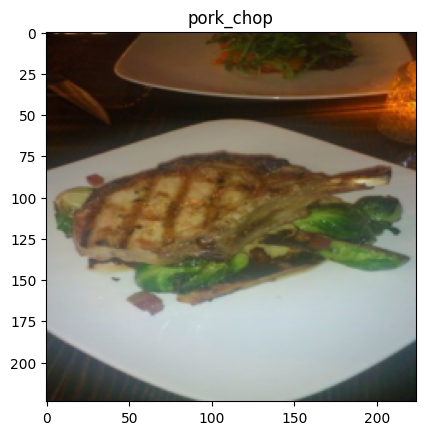

In [9]:
plot.imshow(image_batch[-1], title=classes[label_batch[-1]])

In [12]:
plot.image_grid??

Signature:
plot.image_grid(
    images,
    labels,
    idx_to_class,
    rows=2,
    cols=4,
    figsize=(20, 10),
)
Source:   
def image_grid(images, labels, idx_to_class, rows=2, cols=4, figsize=(20, 10)):
    """
    Plots a grid of images and their labels.

    Args:
        images (torch.Tensor): Images to be plotted
        labels (torch.Tensor): Labels for the images
        idx_to_class (dict): Dictionary mapping indices to class names
        rows (int): Number of rows in the grid
        cols (int): Number of columns in the grid
        figsize (tuple): Size of the figure
    
    Returns:
        None
    """
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax = imshow(images[i], ax=ax, title=idx_to_class[labels[i].item()])
    plt.tight_layout()
    plt.show()
File:      ~/Nutri-2.0/helper/plot.py
Type:      function

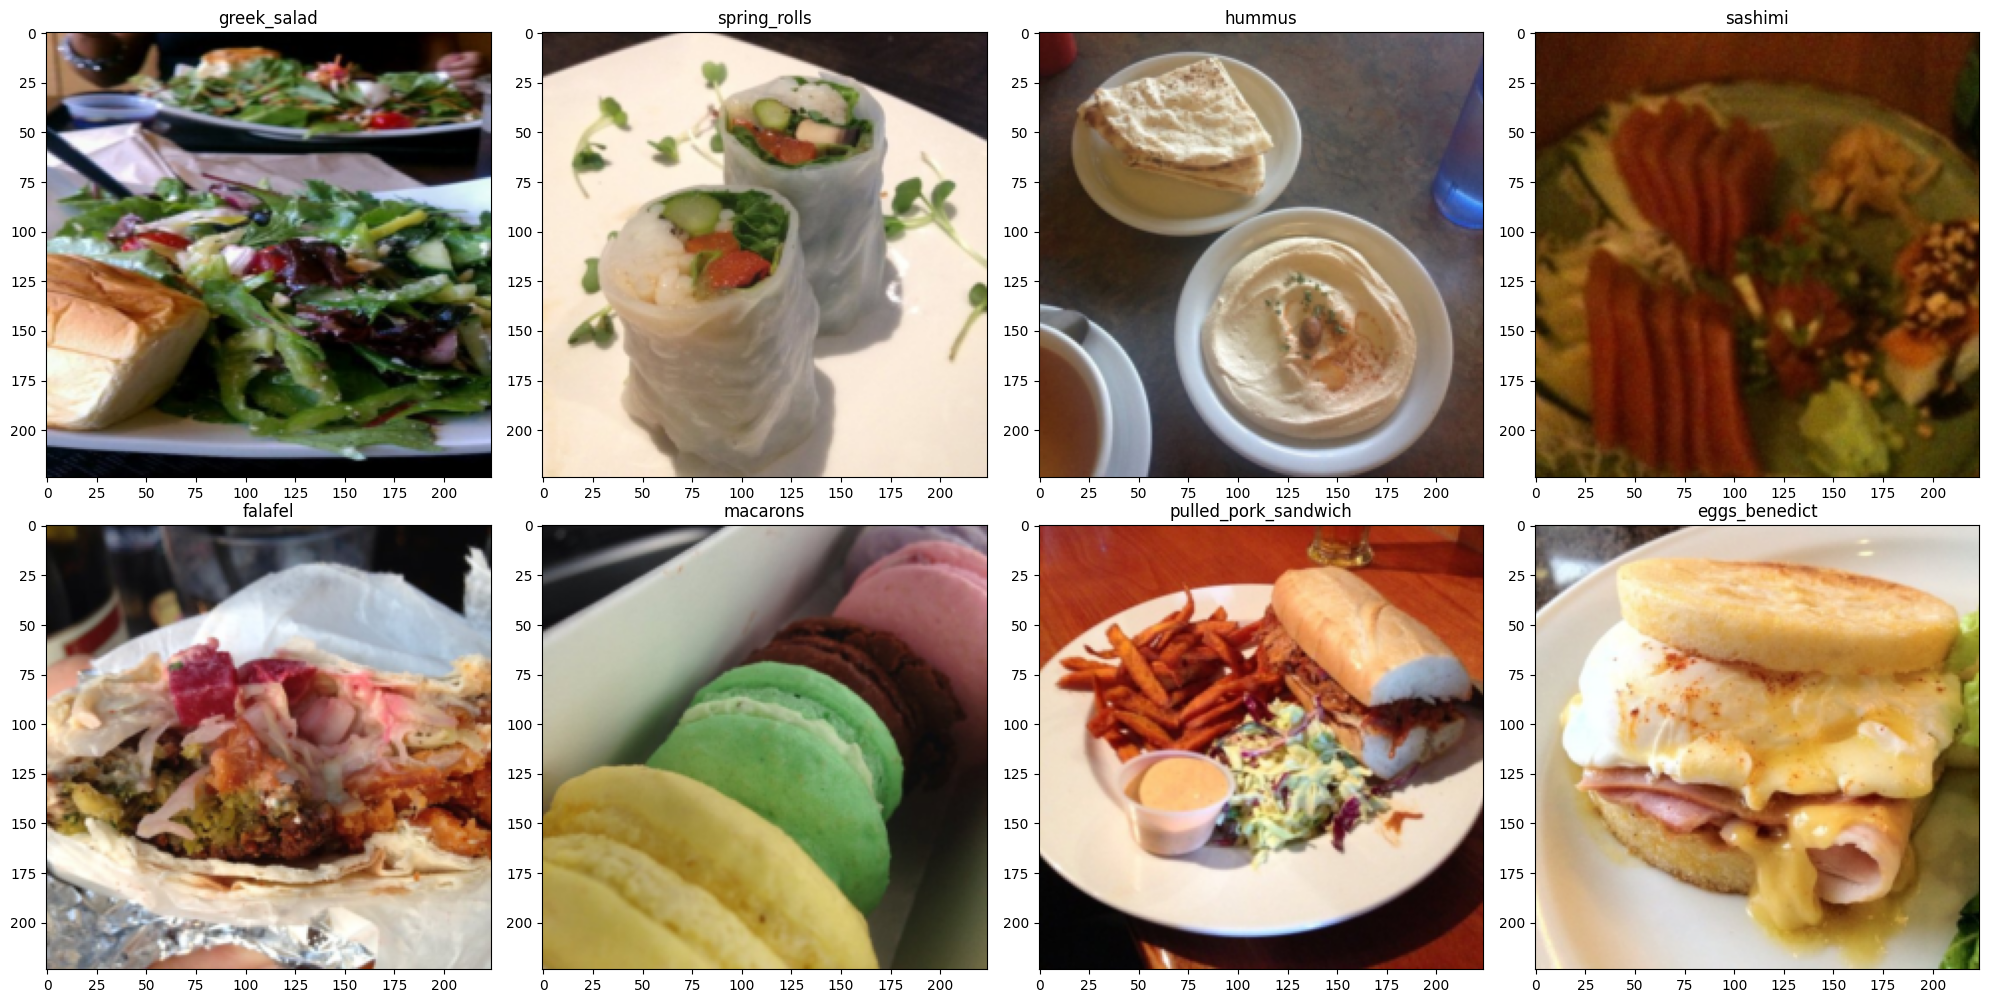

In [13]:
plot.image_grid(image_batch, label_batch, idx_to_class)

## Replication

### Patch (with Positional) Embedding (and classifier tokens)

In [15]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# Hence
number_of_patches = height * width // (patch_size**2)
print(f"Number of patches for height {height} and width {width} with patch size {patch_size} is {number_of_patches}")

Number of patches for height 224 and width 224 with patch size 16 is 196
